# Classification using Vectorizer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from konlpy.tag import Okt

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
train.head()

(25000, 3)


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
 2   target   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


## EDA

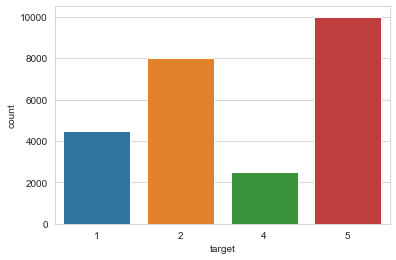

In [4]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='target')
plt.show()

라벨 간 불균형을 확인

## Preprocess Data

In [5]:
okt = Okt()
stop_words = stopwords.words('korean')
train_data = list()
train_label = train.target.tolist()
test_data = list()

for review in train['reviews'].tolist():
    tokenized = okt.morphs(review, stem=True)
    tokenized = [word for word in tokenized if word not in stop_words]
    train_data.append(tokenized)
for review in test['reviews'].tolist():
    tokenized = okt.morphs(review, stem=True)
    tokenized = [word for word in tokenized if word not in stop_words]
    test_data.append(tokenized)

print('Train Sample:', train_data[0])
print('Test Sample:', test_data[0])

Train Sample: ['좋다', '처음', '구입', '싸다', '햇', '요']
Test Sample: ['채소', '시들다']


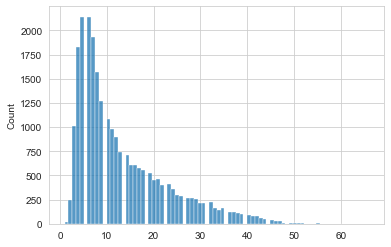

In [6]:
sns.set_style('whitegrid')
sns.histplot([len(seq) for seq in train_data])
plt.show()

## Word2Vec

In [7]:
from gensim.models import Word2Vec

num_features = 300
model = Word2Vec(sentences=train_data, vector_size=num_features, window=5, min_count=5, workers=4, sg=0)

In [8]:
model_result = model.wv.most_similar('좋다')
print(model_result)

[('만족스럽다', 0.9126099944114685), ('만족하다', 0.9103996157646179), ('튼튼하다', 0.8792112469673157), ('고급스럽다', 0.8789305090904236), ('귀엽다', 0.875070333480835), ('가볍다', 0.8725149631500244), ('잘쓰다', 0.8719117045402527), ('넉넉하다', 0.8694740533828735), ('간편하다', 0.8664718270301819), ('~~', 0.8626538515090942)]


In [9]:
model_result = model.wv.most_similar('시들다')
print(model_result)

[('도대체', 0.9820369482040405), ('이미', 0.9817062020301819), ('닦다', 0.9808083772659302), ('찝찝하다', 0.980341911315918), ('놔두다', 0.9791481494903564), ('풀리다', 0.9780338406562805), ('박아', 0.9776930212974548), ('이로', 0.9773398637771606), ('떨어뜨리다', 0.9771440625190735), ('내다', 0.9770815372467041)]


## TFIDF + Cosine Similarity
- Public accuracy: 0.36208

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words=stop_words)
train_data = vectorizer.fit_transform(train.reviews.tolist())
train_label = np.array(train.target)
test_data = vectorizer.transform(test.reviews.tolist())

train_data.shape, test_data.shape

((25000, 74349), (25000, 74349))

In [ ]:
similarity = cosine_similarity(train_data, test_data)
simi_index = similarity.argsort()[:, ::-1]

In [ ]:
from collections import Counter

for idx in range(10):
    simi_reviews = simi_index[idx][:10]
    pred = Counter([train_label[i] for i in simi_reviews]).most_common(1)
    print(test['reviews'][idx], pred[0][0])

채소가 약간 시들어 있어요 2
발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리지를 못함 딱딱한 테이프 찾고있는데 또 돈 날렸어요.. 5
부들부들 좋네요 입어보고 시원하면 또 살게요 2
이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임? 2
검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요 5
흠 마무리가 넘 안좋아요 가격대비 그냥써봅니다 5
조금 찌거러져서 왔지만 그냥 써야죠 뭐.. 신경 좀 써주세요. 5
잘 빠져요. 새다리들만 쓸수 있을듯해요.그냥 tv볼때 요거 위에다 다리올려놓고 봅니다. 5
재구매 가격저령하구요 상품질도 좋으네요~ 또이용하겠습니다 2
재구매 아이가 너무 좋아합니다 배송도 빠르고 사은품도 너무 좋네요~~ 2


## TFIDF + Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split

# TFIDF가 적용된 데이터를 분리
train_X, val_X, train_y, val_y = \
    train_test_split(train_data, train_label, test_size=0.3, stratify=train_label)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(train_X, train_y)

LogisticRegression(max_iter=500)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(val_X)
accuracy = accuracy_score(val_y, y_pred)

print(f'모델의 정확도는 {accuracy*100:.2f}% 입니다')

모델의 정확도는 61.79% 입니다


In [ ]:
y_pred = model.predict(val_X[0])
print('예측 라벨 : ', y_pred)
print('실제 라벨 : ', val_y[0])

예측 라벨 :  [2]
실제 라벨 :  2


In [ ]:
vectorizer.inverse_transform(val_X[0])

[array(['뭔가요', '나오는건', '껍질같은게'], dtype='<U100')]

## Submission

In [ ]:
submission = pd.read_csv("../data/sample_submission.csv") 
submission.head() 

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submission['target'] = model.predict(test_data)
submission.head() 

,id,target
0,0,5
1,1,2
2,2,5
3,3,2
4,4,1


In [ ]:
submission.to_csv("../data/samples/tfidf.csv",index=False)